___
<a href='https://towardsdatascience.com/rlcard-building-your-own-poker-ai-in-3-steps-398aa864a0db'> <img src='https://miro.medium.com/max/1000/1*_9abDpNTM9Cbsd2HEXYm9Q.png' width=500 /></a>
___
# Example for no-limit Texas Holdem in R

### Let's train our first Texas Holdem in R!

## > Install packages
To begin with, we install `reticulate`, a package that embeds the Python session within the R session. Specifically, in our tutorial, the `reticulate` is used for virtual environment creation and Python packages connection. Then, we install the package `imager` for the curve plotting of the training performance.

In [18]:
install.packages("reticulate")
library(reticulate)

Installing package into ‘/usr/local/lib/R/4.0/site-library’
(as ‘lib’ is unspecified)



In [2]:
install.packages("imager")
library(imager)

Installing package into ‘/usr/local/lib/R/4.0/site-library’
(as ‘lib’ is unspecified)

Loading required package: magrittr


Attaching package: ‘imager’


The following object is masked from ‘package:magrittr’:

    add


The following objects are masked from ‘package:stats’:

    convolve, spectrum


The following object is masked from ‘package:graphics’:

    frame


The following object is masked from ‘package:base’:

    save.image




## > Virtual Environment
Now we create a virtual environment called "r-rlcard"


In [19]:
virtualenv_create('r-rlcard')

virtualenv: r-rlcard


Before using the virtual environment `r-rlcard`, let's double-check if it exists.

In [4]:
virtualenv_list()
use_virtualenv('r-rlcard', required=TRUE)

[1] "r-rlcard"

## >  Import packages
First, we use `py_install()` to install `Rlcard` and `Tensorflow` in R. We recommend to use `'pip = TURE'` for installation because the default conda install method may occur issues.

In [5]:
py_install('rlcard', pip=TRUE)
py_install('rlcard[tensorflow]', pip=TRUE)

Using virtual environment '/Users/miawan/.virtualenvs/r-rlcard' ...
Using virtual environment '/Users/miawan/.virtualenvs/r-rlcard' ...


Then, we import the installed packages and check if the `TensorFlow` version agrees with our needs.

In [6]:
rlcard <- import('rlcard')
tf <- import('tensorflow')
os <- import('os')

In [7]:
tf$"__version__"

[1] "1.14.0"

## > Deep-Q Agent model setup

First, we import the modules that are warped up in rlcard packages. Then, we set the iterations numbers, the initial memory size and how frequently we evaluate the performance. Remember to have `L` to keep the datatype. Finally, we save the performance data and learning curves to our current path as `./log`. 

In [8]:
# Import the modules.
DQNAgent <- rlcard$agents$DQNAgent
RandomAgent <- rlcard$agents$RandomAgent
set_global_seed <- rlcard$utils$set_global_seed
tournament <- rlcard$utils$tournament
Logger <- rlcard$utils$Logger

In [9]:
env = rlcard$make('no-limit-holdem')
eval_env = rlcard$make('no-limit-holdem')

# Set the iterations numbers and how frequently we evaluate the performance.
evaluate_every = 100L
evaluate_num = 1000L
episode_num = 10000L

# Set the intial memory size.
memory_init_size = 1000L

# Train the agent every X steps.
train_every = 1

# Set the paths for saving the logs and learning curves. We save it on our current path.
log_dir = './log'

Before starting the training process, we initial a global step and set up the DQN agents. The Logger is used to plot the learning curve and save it to the same directory as we set up for log.

In [10]:
# Set a global seed.
set_global_seed(0L)
sess <- tf$Session()

# Initialize a global step.
global_step = tf$Variable(0L, name='global_step', trainable=F)

In [11]:
# Set up the DQN agents.
agent = DQNAgent(
  sess,
  scope='dqn',
  action_num=env$action_num,
  replay_memory_init_size = memory_init_size,
  train_every=train_every,
  state_shape=env$state_shape,
  mlp_layers=c(512, 512)
)

random_agent = RandomAgent(action_num=eval_env$action_num)
env$set_agents(list(agent, random_agent))
eval_env$set_agents(list(agent, random_agent))

In [12]:
# Initialize global variables and a Logger to plot the learning curve.
sess$run(tf$global_variables_initializer())
logger = Logger(log_dir)

## > Train the model


Training the model requires complicated interactions with Tensorflow. Thus, we recommend importing a Python script. Specifically, we create a file named `train.py` in the same directory with content as follows.


    def train(episode_num, env, eval_env, evaluate_every, evaluate_num, agent, logger, tournament):
       for episode in range(episode_num):
     
         # Generate data from the environment
         trajectories, _ = env.run(is_training = True)

         # Feed transitions into agent memory, and train the agent
         for ts in trajectories[0]:
             agent.feed(ts)

         # Evaluate the performance. Play with random agents.
         if episode % evaluate_every == 0:
             logger.log_performance(env.timestep, tournament(eval_env, evaluate_num)[0])

Now we use the `train.py` to train the model

In [13]:
reticulate::source_python("train.py")
train(episode_num, env, eval_env, evaluate_every, evaluate_num, agent, logger, tournament)

Close files in the logger and Plot the learning curve in our file.

In [14]:
logger$close_files()
logger$plot('DQN')

Let's display our training performace and the plot.

timestep,reward
<int>,<dbl>
2,4.264
290,0.839
596,1.113
888,2.163
1203,-0.073
1483,0.547
1789,2.605
2084,0.183
2373,2.797


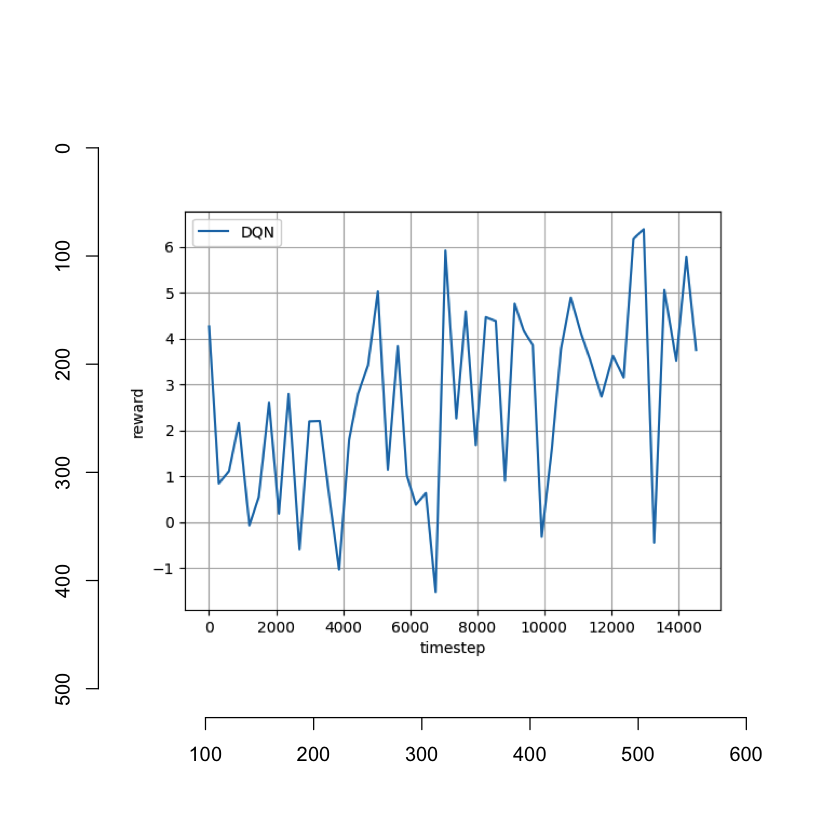

In [15]:
txt <- read.csv(file='./log/performance.csv')
txt

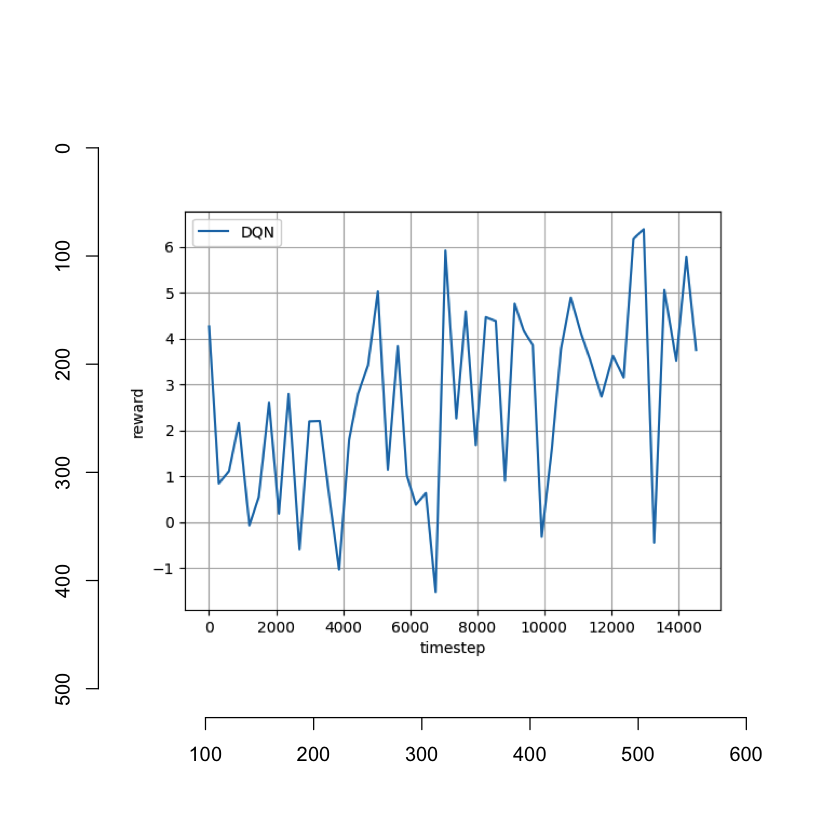

In [16]:
library(imager)
load.image("~/Desktop/log/fig.png") %>% plot

In the end, we save the trained model to `models/leduc_holdem_nfsp` .

In [17]:
save_dir = 'models/leduc_holdem_nfsp'
if (!dir.exists(save_dir)){
    os$makedirs(save_dir)}
saver = tf$train$Saver()
saver$save(sess, os$path$join(save_dir, 'model'))

[1] "models/leduc_holdem_nfsp/model"

### Now you have your no-limit Texas Holdem model.
## Good Job!

___